In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
!pip install pytorchcv

     |████████████████████████████████| 368kB 2.8MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import fastai
from fastai.vision import *
from pytorchcv.model_provider import get_model as ptcv_get_model
import warnings
warnings.filterwarnings('ignore')

In [5]:
print(fastai.__version__)

1.0.59


In [6]:
path = Path("/content/drive/My Drive/dla-project/data/")
path.ls()

[PosixPath('/content/drive/My Drive/dla-project/data/test'),
 PosixPath('/content/drive/My Drive/dla-project/data/train')]

In [0]:
bs = 32 
size = 299
tfms = ([crop_pad()], [])

In [8]:
src = ImageList.from_folder(path/'train').split_by_rand_pct().label_from_folder().transform(tfms, size=size)   
src

LabelLists;

Train: LabelList (884 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
turbines_low_capacity,turbines_low_capacity,turbines_low_capacity,turbines_low_capacity,turbines_low_capacity
Path: /content/drive/My Drive/dla-project/data/train;

Valid: LabelList (220 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
turbines_medium_capacity,no_turbines_med_potential,turbines_high_capacity,turbines_medium_capacity,turbines_medium_capacity
Path: /content/drive/My Drive/dla-project/data/train;

Test: None

In [0]:
#Creating Databunch (Loaders) and Normalizing
data = (src).databunch(bs=bs).normalize(imagenet_stats)

In [0]:
#Labels
data.classes

['no_turbines_high_potential',
 'no_turbines_low_potential',
 'no_turbines_med_potential',
 'no_turbines_no_potential',
 'turbines_high_capacity',
 'turbines_low_capacity',
 'turbines_medium_capacity']

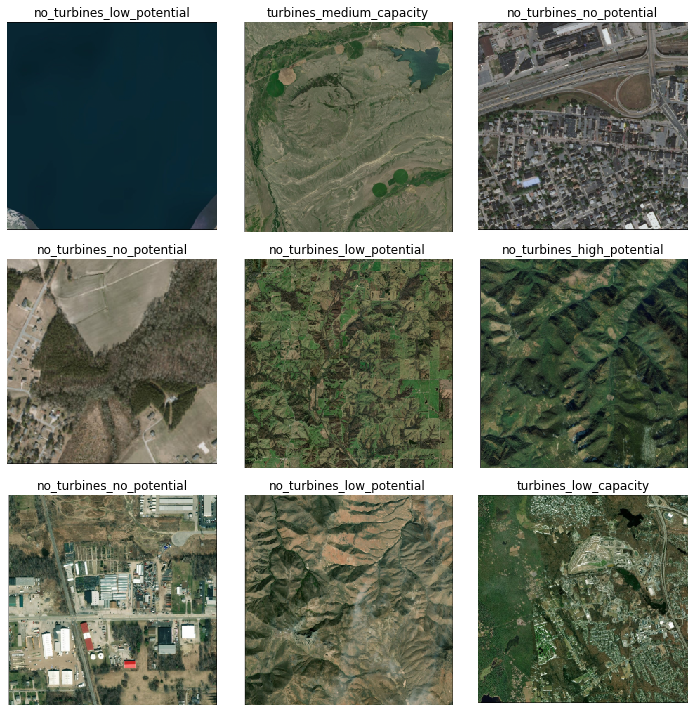

In [0]:
#Example Batch
data.show_batch(rows=3, figsize=(10, 10))

In [0]:
#https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/utils.py
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')


def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

In [0]:
arch = ptcv_get_model("inceptionv3", pretrained=True)
arch_summary(lambda _: arch.features)

(0) InceptInitBlock: 17  layers (total: 17)
(1) Sequential  : 66  layers (total: 83)
(2) Sequential  : 137 layers (total: 220)
(3) Sequential  : 75  layers (total: 295)
(4) AvgPool2d   : 1   layers (total: 296)


In [0]:
for i in range(4):
    print(f'---------({i})---------')
    arch_summary(lambda _: arch.features[i])

---------(0)---------
(0) InceptConv  : 3   layers (total: 3)
(1) InceptConv  : 3   layers (total: 6)
(2) InceptConv  : 3   layers (total: 9)
(3) MaxPool2d   : 1   layers (total: 10)
(4) InceptConv  : 3   layers (total: 13)
(5) InceptConv  : 3   layers (total: 16)
(6) MaxPool2d   : 1   layers (total: 17)
---------(1)---------
(0) InceptionAUnit: 22  layers (total: 22)
(1) InceptionAUnit: 22  layers (total: 44)
(2) InceptionAUnit: 22  layers (total: 66)
---------(2)---------
(0) ReductionAUnit: 13  layers (total: 13)
(1) InceptionBUnit: 31  layers (total: 44)
(2) InceptionBUnit: 31  layers (total: 75)
(3) InceptionBUnit: 31  layers (total: 106)
(4) InceptionBUnit: 31  layers (total: 137)
---------(3)---------
(0) ReductionBUnit: 19  layers (total: 19)
(1) InceptionCUnit: 28  layers (total: 47)
(2) InceptionCUnit: 28  layers (total: 75)


In [0]:
def inceptionv3(pretrained=True):
    return ptcv_get_model("inceptionv3", pretrained=pretrained).features

In [0]:
#Fastai Learner (Model with built-in Training Tools)
learn = cnn_learner(data, inceptionv3, pretrained=True, metrics=[error_rate, accuracy], cut=noop, split_on=lambda m: (m[0][3], m[1]), bn_final=True)
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 149, 149]       864        False     
______________________________________________________________________
BatchNorm2d          [32, 149, 149]       64         True      
______________________________________________________________________
ReLU                 [32, 149, 149]       0          False     
______________________________________________________________________
Conv2d               [32, 147, 147]       9,216      False     
______________________________________________________________________
BatchNorm2d          [32, 147, 147]       64         True      
______________________________________________________________________
ReLU                 [32, 147, 147]       0          False     
______________________________________________________________________
Conv2d               [64, 147, 147]       18,432     False     
___________________________________________________

In [0]:
get_groups(nn.Sequential(*learn.model[0], *learn.model[1]), learn.layer_groups)

Group 1: ['InceptInitBlock', 'Sequential', 'Sequential']
Group 2: ['Sequential', 'AvgPool2d']
Group 3: ['AdaptiveConcatPool2d', 'Flatten', 'BatchNorm1d', 'Dropout', 'Linear', 'ReLU', 'BatchNorm1d', 'Dropout', 'Linear', 'BatchNorm1d']


In [0]:
gc.collect()

23

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


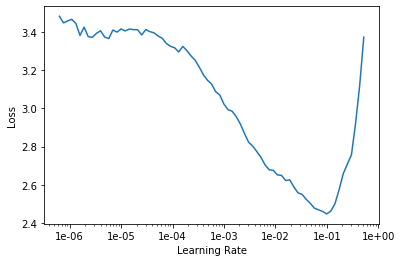

In [0]:
learn.lr_find(wd=2e-2)
learn.recorder.plot()

In [0]:
gc.collect()

0

In [0]:
learn.fit_one_cycle(4, 4e-2, wd=2e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.401053,1.547006,0.459091,0.540909,06:41
1,1.126772,1.393927,0.454545,0.545455,03:46
2,0.925548,1.090297,0.377273,0.622727,03:42
3,0.718494,1.065303,0.350000,0.650000,03:43


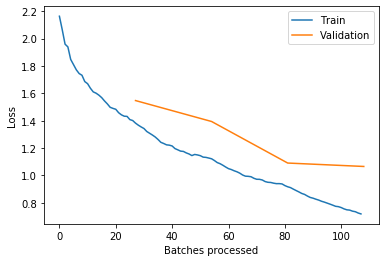

In [0]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
gc.collect()

2848

In [0]:
#Save .pth File  
learn.save('wfs-incept-phase1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


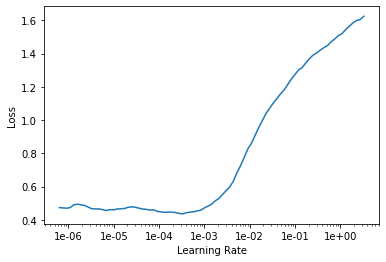

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
gc.collect()

7456

In [0]:
learn.fit_one_cycle(4, (4e-4,4e-4,4e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.580798,1.644217,0.445455,0.554545,03:45
1,0.631124,1.259256,0.409091,0.590909,03:45
2,0.535062,0.946542,0.318182,0.681818,03:46
3,0.410609,0.891493,0.322727,0.677273,03:44


In [0]:
gc.collect()

14

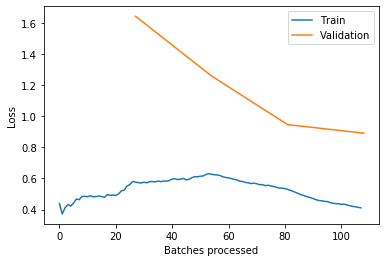

In [0]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
#Save .pth File  
learn.save('wfs-incept-phase2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


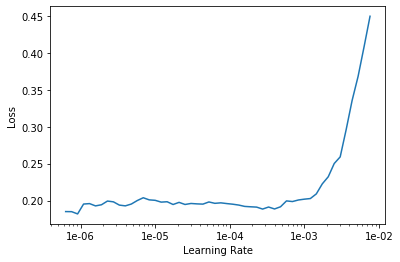

In [0]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


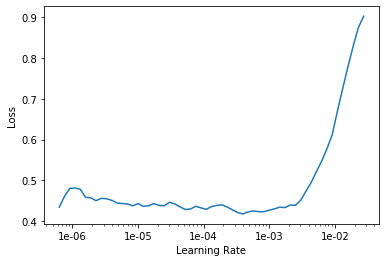

In [0]:
#Generate New Augmented Images
size=331
src = ImageList.from_folder(path/'train').split_by_rand_pct().label_from_folder().transform(tfms, size=size)   
data2 = (src).databunch(bs=bs).normalize(imagenet_stats)
#Attach to the Learner 
learn.data = data2 
learn.lr_find()
learn.recorder.plot()

In [0]:
gc.collect()

6293

In [0]:
learn.fit_one_cycle(4, (4e-5,4e-5,4e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.428731,0.302916,0.081818,0.918182,03:55
1,0.370551,0.311634,0.090909,0.909091,03:57
2,0.303556,0.305417,0.104545,0.895455,04:00
3,0.259590,0.300337,0.081818,0.918182,04:03


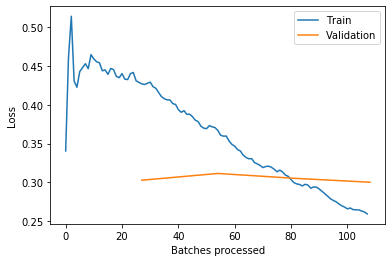

In [0]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
gc.collect()

2747

In [0]:
#Save .pth File  
learn.save('wfs-incept-phase3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


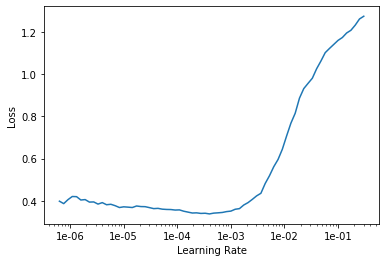

In [0]:
#Generate New Augmented Images
size=362
src = ImageList.from_folder(path/'train').split_by_rand_pct().label_from_folder().transform(tfms, size=size)   
data3 = (src).databunch(bs=bs).normalize(imagenet_stats)
#Attach to the Learner 
learn.data = data3
#learn.freeze() 
learn.lr_find()
learn.recorder.plot()

In [0]:
gc.collect()

6780

In [0]:
learn.fit_one_cycle(4, (4e-5,4e-4,4e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.334891,0.208332,0.045455,0.954545,04:12
1,0.345892,0.318783,0.081818,0.918182,04:14
2,0.317147,0.277696,0.068182,0.931818,04:12
3,0.259724,0.284411,0.050000,0.950000,04:09


In [0]:
gc.collect()

14

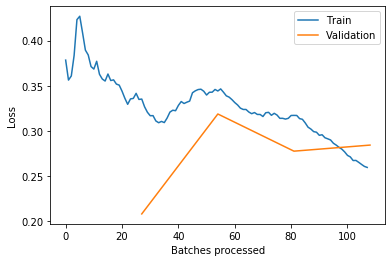

In [0]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
#Save .pth File  
learn.save('wfs-incept-phase4')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


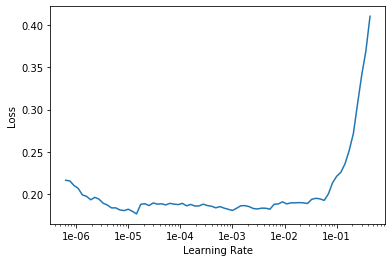

In [0]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
gc.collect()

6808

In [0]:
learn.fit_one_cycle(2, 4e-5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.203036,0.289299,0.054545,0.945455,04:04
1,0.200674,0.281749,0.050000,0.950000,04:02


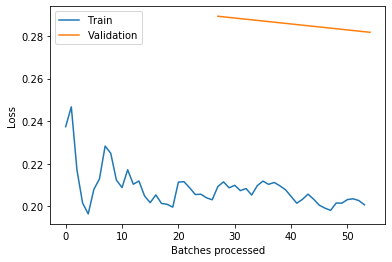

In [0]:
#Losses for First Fitting
learn.recorder.plot_losses()

In [0]:
learn.export(file="incept-v3-c95.pkl")

In [0]:
gc.collect()

2690

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.plot_top_losses(9, figsize=(20, 20))

Output hidden; open in https://colab.research.google.com to view.

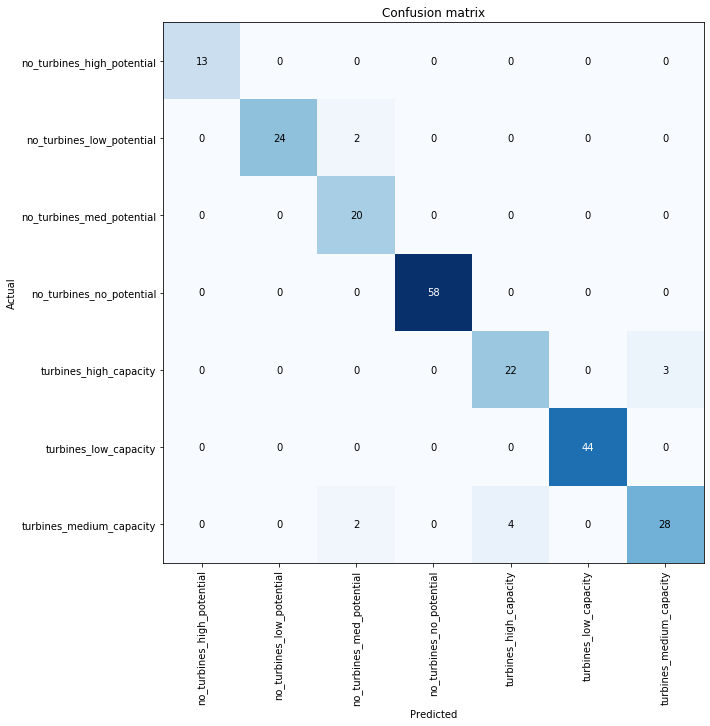

In [0]:
interp.plot_confusion_matrix(figsize=(10, 10))